In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# import os
# ! pip install wget
# import wget
# wget.get_console_width = lambda:80

# def get_lib(url):
#     if not os.path.isfile(url.split('/')[-1]):
#         wget.download(url)
        
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/PlotCallback.py')
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/lab_helper.py')
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/multiclass_helper.py')
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/initial_weights_inverted.hdf5')
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/initial_weights_cut_half.hdf5')
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/initial_weights_almost_right.hdf5')
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/initial_weights_poly_4.hdf5')
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/final_weights_poly_4.hdf5')
# get_lib('https://github.com/lab-ml-itba/regresion-logistica-Keras/raw/master/TensorboardMPLCallback.py')


In [4]:
import numpy as np
from lab_helper import plot_boundaries, plot_boundaries_keras
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
from PlotCallback import PlotCallback
from multiclass_helper import draw_neural_net
from keras import backend as K
import tensorflow as tf


/Users/julian/opt/anaconda3/envs/pef/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
def generate_gaussians_distributions(sep=1, N=500, random_state=42, normalize=True):
    np.random.seed(random_state)
    # Zeros
    X1 = np.random.multivariate_normal(sep*np.array([0.5, 0.5]), [[0.1,-0.085],[-0.085,0.1]], N//2)
    # Ones
    X2 = np.random.multivariate_normal([-0.25, -0.25], [[0.1,0],[0,0.1]], N//2)
    X = np.append(X1, X2, axis=0)
    y = np.append(np.zeros(N//2), np.ones(N//2))
    indexes = np.arange(len(y))
    np.random.shuffle(indexes)
    if normalize:
        X = (X - X.mean(axis=0))/X.std(axis=0)
    else:
        X[:, 0] = X[:, 0]
        X[:, 1] = X[:, 1]
    return X[indexes], y[indexes]

In [6]:
# Primero probar con N = 3000 para ver bien las distribuciones
X, y = generate_gaussians_distributions(sep=0.5, N = 500, normalize=False, random_state=41)

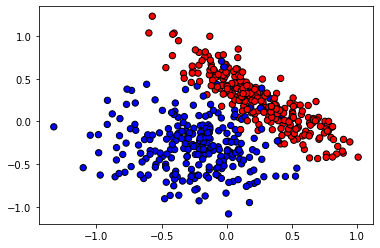

In [7]:
plot_boundaries(X,y)

# Armo modelo

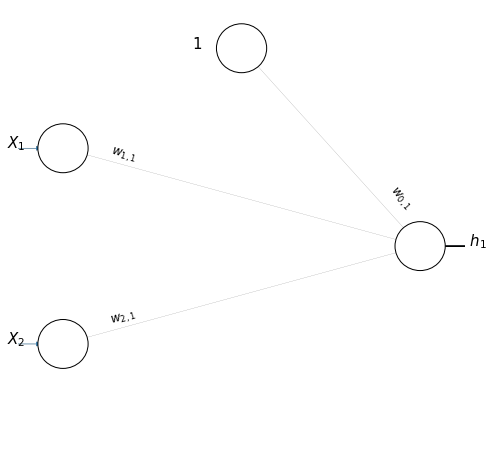

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
biases = [['$w_{0,1}$']]
capa_1 = [['$w_{1,1}$'],
          ['$w_{2,1}$']]
weights = [np.array(capa_1), [['1']]]
draw_neural_net(ax, 0.1, 0.9, 0, 0.9, [2,1], weights, biases)
plt.show()

# Pruebas a realizar:
- Ver situaciones particulares de inicialización: initial_weights_almost_right, initial_weights_inverted, initial_weights_cut_half
- Sin normalizar, lr=0.01, bins=30, sep=2, N=500
- Subir lr para acelerarlo
- Inicialización aleatoria, initial_weights_inverted.hdf5, initial_weights_cut_half.hdf5
- Normalizando,  lr=0.01, bins=30, sep=2,  N=500
- lr=0.01 hasta 10, hablar sobre cyclic learning rate
- ADAM con lr 10 llega a loss = 0 rapidamente
- ADAM con lr 2 llega a loss = 0 rapidamente despues de 40 epochs
- sep=1, lr = 1, batch_size=1, cambiarlo a batch_size=100 y comparar (Al final del entrenamiento)

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [10]:
model = Sequential()
# Que pasa si no pongo la función de activación??!
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

In [11]:
# model.save_weights('initial_weights_almost_right.hdf5')

In [12]:
# model.load_weights('initial_weights_almost_right.hdf5')
model.load_weights('initial_weights_inverted.hdf5')
# model.load_weights('initial_weights_cut_half.hdf5')

model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
from keras.callbacks import Callback

In [14]:
class TensorBoardImage(Callback):
    def __init__(self, tag):
        super().__init__() 
        self.tag = tag

    def on_epoch_end(self, epoch, logs={}):
        # Load image
        img = data.astronaut()
        # Do something to the image
        img = (255 * skimage.util.random_noise(img)).astype('uint8')

        image = make_image(img)
        summary = tf.Summary(value=[tf.Summary.Value(tag=self.tag, image=image)])
        writer = tf.summary.FileWriter('./logs')
        writer.add_summary(summary, epoch)
        writer.close()

        return

In [15]:
from TensorboardMPLCallback import PlotCallbackTB

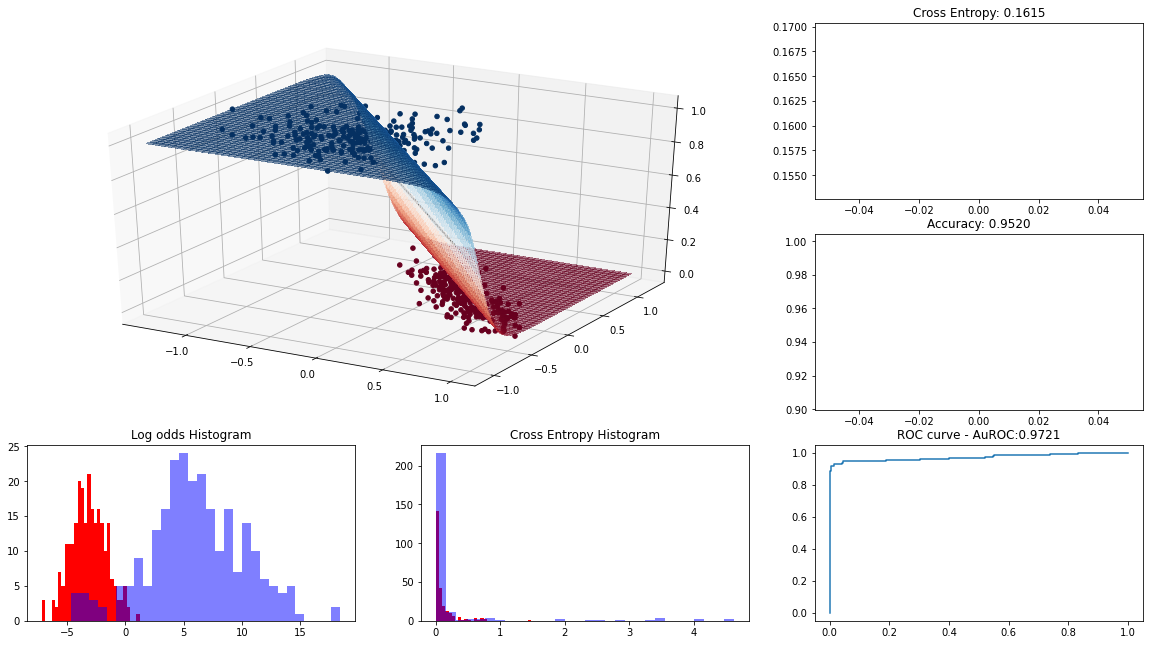

5/5 [==============================] - 2s 397ms/step - loss: 0.1615 - accuracy: 0.9520


In [81]:
# Arrancar con lr = 0.01, bs=128
K.set_value(model.optimizer.lr, 0.01)
# Probar distintos tipos de verbose
# plotCallback = PlotCallback(X, y, bins=30)
tbMLPCallback = PlotCallbackTB(X, y, bins=30)
model.fit(X, y, epochs=1, verbose=1, callbacks=[tbMLPCallback], batch_size=100)
# model.fit(X, y, epochs=20, verbose=1, batch_size=128)

$log\_odds = \log(\large \frac{p_i}{1-p_i})$

$CE = - [y_i log(p_i) + (1-y_i) log(1-p_i)]$

In [82]:
# 400, 0,  11
i = 11
print(X[i:i+1][0])
p = model.predict(X[i:i+1])[0][0]
print(f'probabilidad: {p}')
print(f'log_odds: {np.log(p/(1-p))}')
print(f'cross_entropy: {-y[i]*np.log(p) - (1-y[i])*np.log(1-p)}')

[ 0.0192967  -0.38217853]
probabilidad: 0.989760160446167
log_odds: 4.571176700685212
cross_entropy: 0.010292627848684788


(27722, 1)


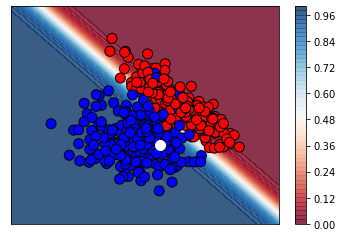

In [83]:
f, ax = plt.subplots(1, 1)
plot_boundaries_keras(X, y, None, model.predict_proba, ax=ax)
ax.scatter(X[i][0], X[i][1], s=100, color='w')

# Que parámetros aprendió el modelo?

In [84]:
model.get_weights()

[array([[-9.421655 ],
        [-8.8718605]], dtype=float32),
 array([1.3623486], dtype=float32)]

In [85]:
coefs_, intercept_ = model.get_weights()

In [86]:
coefs_

array([[-9.421655 ],
       [-8.8718605]], dtype=float32)

In [88]:
intercept_

array([1.3623486], dtype=float32)

# Probabilidad de observación

In [89]:
observ = np.array([[0.5, 1]])
print(observ)

[[0.5 1. ]]


In [90]:
model.predict_proba(observ)

array([[4.9291757e-06]], dtype=float32)

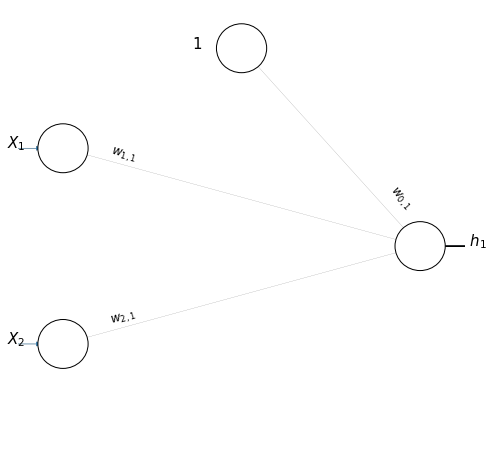

In [91]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
biases = [['$w_{0,1}$']]
capa_1 = [['$w_{1,1}$'],
          ['$w_{2,1}$']]
weights = [np.array(capa_1), [['1']]]
draw_neural_net(ax, 0.1, 0.9, 0, 0.9, [2,1], weights, biases)
plt.show()

In [92]:
h1 = observ.dot(coefs_) + intercept_
print(h1)

[[-12.2203393]]


In [93]:
p_ = 1/(1+np.exp(-h1))
print(p_)

[[4.92914887e-06]]


# Cálculo de loss y accuracy

In [95]:
y_true = 1
model.evaluate([[0.5, 1]], [y_true])

1/1 [==============================] - 0s 838us/step - loss: 12.2203 - accuracy: 0.0000e+00


[12.220343589782715, 0.0]

In [315]:
y_true*np.log(1/(p_)) + (1-y_true)*np.log(1/(1-p_))

array([[1.06915656]])

In [8]:
np.log10(0.85144224)

-0.06984480830044822